In [2]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('train.csv')
df.drop("id", axis = 1, inplace = True)
df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [26]:
x, y = df.drop('Hardness', axis=1), df['Hardness']


In [27]:
# ______________________________________________________________________________________
# Pipeline

# one hot encoder
ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
    drop='first'
).set_output(transform='pandas')

trans_ohe = make_column_transformer(
    ('passthrough', make_column_selector(dtype_exclude=object)),
    (ohe, make_column_selector(dtype_include=object)),
    verbose_feature_names_out=False
).set_output(transform='pandas')


# scaler
scl_std = StandardScaler().set_output(transform = "pandas")
scl_mm = MinMaxScaler().set_output(transform = "pandas")


# model
dtc = DecisionTreeRegressor(
    random_state = 24,
    # max_depth = 4
)


pipe_pca = Pipeline([("OHE", trans_ohe), ("SCL", scl_std), ("DTC", dtc)])


# _____________________________________________________________________________________
# GCV

params = {
    "DTC__max_depth" : [None, 4, 6, 8, 10, 12, 14, 16, 18],
    "DTC__min_samples_leaf" : [1, 5, 10, 25, 50],
    "DTC__min_samples_split" : [2, 10, 25, 50],
}

kfolds = StratifiedKFold(n_splits = 5,
                        random_state = 24,
                        shuffle = True)

kfold = KFold(n_splits = 5,
              random_state = 24,
              shuffle = True)

gcv = GridSearchCV(pipe_pca,
                  param_grid = params,
                  scoring = "r2",
                  cv = kfold,
                  verbose = 3)

gcv.fit(x, y)
# gcv.fit(x, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=2;, score=-0.051 total time=   0.1s
[CV 2/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=2;, score=-0.117 total time=   0.1s
[CV 3/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=2;, score=-0.067 total time=   0.1s
[CV 4/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=2;, score=-0.068 total time=   0.1s
[CV 5/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=2;, score=-0.088 total time=   0.1s
[CV 1/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=10;, score=0.091 total time=   0.1s
[CV 2/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=10;, score=0.048 total time=   0.1s
[CV 3/5] END DTC__max_depth=None, DTC__min_samples_leaf=1, DTC__min_samples_split=10;, score=0.067 total time= 

GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('OHE',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x79fbe2e1a170>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x79fbdd6ac940>)],
                                                          verbose_feature_names_out=False)),
                                       ('SCL', StandardScaler()),
                                       ('DTC',
                                        DecisionTreeRegressor(random_state=24))]),
             param_grid={'DTC__max_depth': [None, 4, 6, 8, 10, 12, 14, 16, 18],
                         'DTC__min_samples_leaf': [1, 5, 10, 25, 50],
                         'DTC__min_samples_split': [2, 10, 25, 50]},
             scoring='r2', verbose=3)

In [28]:
print(gcv.best_score_)
print(gcv.best_params_)

0.4040934587284754
{'DTC__max_depth': 10, 'DTC__min_samples_leaf': 25, 'DTC__min_samples_split': 2}


In [ ]:
best_tree = gcv.best_estimator_.named_steps['DTC']

plt.figure(figsize = (50, 35))
plot_tree(best_tree,
          # feature_names = list(X.columns),
          filled = True,
          fontsize = 20,
         )

plt.show()

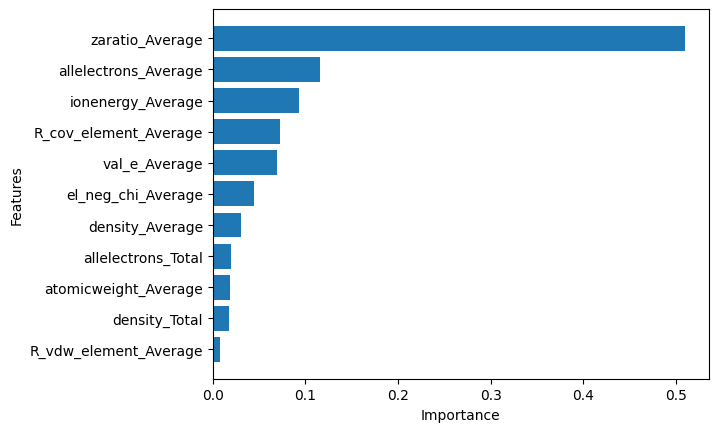

In [30]:
best_tree = gcv.best_estimator_.named_steps['DTC']

df_imp  = pd.DataFrame({"feature" : gcv.best_estimator_.named_steps['OHE'].get_feature_names_out(),
                        "importance" : best_tree.feature_importances_})       # Note here OHE refers to Column transformer not encoder
df_imp.sort_values("importance", inplace = True, )
plt.barh(df_imp["feature"], df_imp["importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


# print(df_imp)

In [31]:
test = pd.read_csv("test.csv")
test.drop("id", axis = 1, inplace = True)
y_pred = gcv.predict(test)
y_pred

array([3.07346939, 3.01020408, 5.73328384, ..., 5.73328384, 4.648     ,
       2.99583333])

In [32]:
sample = pd.read_csv("sample_submission.csv")
sample.Hardness = y_pred
sample.to_csv("submission.csv", index = False)